In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


#q-network_taxi_1

In [0]:
import gym
import numpy as np
import random
import tensorflow as tf

#====== 환경 로딩 =======#
env = gym.make('Taxi-v2')

#====== 신경망 구현 =======#
tf.reset_default_graph()

#행동을 선택하는데 사용되는 신경망의 피드-포워드 부분을 구축한다.
inputs = tf.placeholder(shape=[1, env.observation_space.n], dtype=tf.float32)  #1*500 matrix
weights = tf.Variable(tf.random_uniform([env.observation_space.n,env.action_space.n], 0, 0.01))  #500*6 matrix
q_out = tf.matmul(inputs, weights)  #1*6 matrix
predict = tf.argmax(q_out,1)

# 목표 Q값(ext_q)과 예측 Q값(q_out)의 제곱합을 구함으로써 비용을 얻게 된다.
next_q = tf.placeholder(shape=[1,env.action_space.n],dtype=tf.float32)
loss = tf.reduce_sum(tf.square(next_q - q_out))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
loss_update = trainer.minimize(loss)

#====== 신경망 학습하기 =======#
init = tf.global_variables_initializer()

# 학습 관련 파라미터를 설정한다.
gamma = 0.7
epsilon = 0.2
epsilon_decay = .99
episodes = 100

total_epochs = 0
total_rewards = 0

with tf.Session() as sess:
    sess.run(init)
    for episode in range(episodes):
        #환경을 리셋하고 첫번째 새로운 관측값을 얻는다.
        state = env.reset()
        rewards_this_episode = 0
        epochs = 0

        done = False
        
        # q-network 
        while not done:
            #Q-네트워크로부터 (e의 확률로 랜덤한 액션과 함께) 그리디하게 액션을 선택한다.
            action, q = sess.run([predict,q_out], feed_dict={inputs:np.identity(env.observation_space.n)[state:state + 1]})
            if np.random.rand(1) < epsilon:
                action[0] = env.action_space.sample()

            #환경으로부터 새로운 상태와 보상을 얻는다.                
            next_state, reward, done, info = env.step(action[0])
            #새로운 상태를 네트워크에 피드해줌으로써 Q’값을 구한다.
            curr_q = sess.run(q_out, feed_dict = {inputs:np.identity(env.observation_space.n)[next_state:next_state+1]})
            #maxQ'값을 구하고 선택된 행동에 대한 타겟 값을 설정한다.
            max_next_q = np.max(curr_q)
            target_q = q
            target_q[0, action[0]] = reward + gamma * max_next_q

            #타겟과 예측된 Q값을 이용하여 네트워크를 학습시킨다.
            info, new_weights = sess.run([loss_update, weights], feed_dict={inputs:np.identity(env.observation_space.n)[state:state+1], next_q:target_q})
            rewards_this_episode += reward
            state = next_state
            epochs += 1
        #모델을 학습해 나감에 따라 랜덤 액션의 가능성을 줄여간다.    
        epsilon = epsilon * epsilon_decay
        
        total_epochs += epochs
        total_rewards += rewards_this_episode
        
print ("Percent of succesful episodes: " + str(total_rewards/episodes))



# mountain car dqn

In [0]:
"""
Deep Q-Network: Mountain Car에 적용한 DQN 예제
"""

import numpy as np
import tensorflow as tf
import gym

class DQN:
    def __init__(self, learning_rate, gamma, n_features, n_actions, epsilon, parameter_changing_pointer, memory_size):
        self.learning_rate = learning_rate  #학습률
        self.gamma = gamma            #할인율
        self.n_features = n_features  #자동차의 위치(0)와 속도(1)
        self.n_actions = n_actions    #왼쪽으로 밀기(0), 보류(1), 오른쪽으로 밀기(2) 
        self.epsilon = epsilon        #탐욕 정책 시 활용되는 탐욕의 초기 값       
        self.batch_size = 100         #재생 메모리로부터 추출되는 표본의 크기
        self.experience_counter = 0   #현재 재생 메모리에 저장된 표본의 수
        self.experience_limit = memory_size  #재생 메모리의 최대 용량
        self.replace_target_pointer = parameter_changing_pointer  #target network 갱신 기준 학습 단계
        self.learning_counter = 0                                 #primary network의 학습 단계
        self.memory = np.zeros([self.experience_limit,self.n_features*2+2])  #재생 메모리의 초기값  

        self.build_networks() #primary network과 target network을 생성
        p_params = tf.get_collection('primary_network_parameters')
        t_params = tf.get_collection('target_network_parameters')
        self.replacing_target_parameters = [tf.assign(t,p) for t,p in zip(t_params,p_params)]

        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())

#========== DQN 모형의 기본 신경망 및 목표 신경망을 설정하는 단계 ============#

    def build_networks(self):
        hidden_units = 10
#.....................................................................#
        # Primary Network: 각 10개의 은닉노드를 갖는 2개의 은닉층 
        self.s = tf.placeholder(tf.float32,[None,self.n_features])
        self.qtarget = tf.placeholder(tf.float32,[None,self.n_actions])

        with tf.variable_scope('primary_network'): #변수 볌위를 관리한다.
            c = ['primary_network_parameters', 
					tf.GraphKeys.GLOBAL_VARIABLES]
            # first layer
            with tf.variable_scope('layer1'):
                w1 = tf.get_variable('w1', [self.n_features, hidden_units],
			initializer=tf.contrib.layers.xavier_initializer(),
                                     dtype=tf.float32,collections=c)

                b1 = tf.get_variable('b1', [1, hidden_units],
			initializer=tf.contrib.layers.xavier_initializer(),
                                     dtype=tf.float32,collections=c)

                l1 = tf.nn.relu(tf.matmul(self.s, w1) + b1)

            # second layer
            with tf.variable_scope('layer2'):
                w2 = tf.get_variable('w2', [hidden_units, self.n_actions],
			initializer=tf.contrib.layers.xavier_initializer(),
                                     dtype=tf.float32,collections=c)

                b2 = tf.get_variable('b2', [1, self.n_actions],
			initializer=tf.contrib.layers.xavier_initializer(),
                                     dtype=tf.float32,collections=c)

                self.qeval = tf.matmul(l1, w2) + b2

        with tf.variable_scope('loss'):
                self.loss = tf.reduce_mean(tf.squared_difference(
						self.qtarget, self.qeval))
        with tf.variable_scope('optimiser'):
                self.train = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

#.....................................................................#
        # Target Network
        self.st = tf.placeholder(tf.float32,[None,self.n_features])

        with tf.variable_scope('target_network'):
            c = ['target_network_parameters', tf.GraphKeys.GLOBAL_VARIABLES]
            # first layer
            with tf.variable_scope('layer1'):
                w1 = tf.get_variable('w1', [self.n_features, hidden_units],
				initializer=tf.contrib.layers.xavier_initializer(),
                                     dtype=tf.float32,collections=c)

                b1 = tf.get_variable('b1', [1, hidden_units],
				initializer=tf.contrib.layers.xavier_initializer(),
                                     dtype=tf.float32,collections=c)

                l1 = tf.nn.relu(tf.matmul(self.st, w1) + b1)

            # second layer
            with tf.variable_scope('layer2'):
                w2 = tf.get_variable('w2', [hidden_units, self.n_actions],
				initializer=tf.contrib.layers.xavier_initializer(),
                                     dtype=tf.float32,collections=c)

                b2 = tf.get_variable('b2', [1, self.n_actions],
				initializer=tf.contrib.layers.xavier_initializer(),
                                     dtype=tf.float32,collections=c)

                self.qt = tf.matmul(l1, w2) + b2

#-----------------------------------------------
#기본 신경망의 학습 결과를 목표 신경망에 대입하기 위한 세션을 구성한다
    def target_params_replaced(self):
        self.sess.run(self.replacing_target_parameters)

    def store_experience(self,obs,a,r,obs_):
        index = self.experience_counter % self.experience_limit
        self.memory[index,:] = np.hstack((obs,[a,r],obs_))
        self.experience_counter+=1

#---------------------------------------------------------------
#재생 메모리에 저장된 과거 경험을 설정한 배치 크기만큼 랜덤으로 추출하여 학습 데이터 집합으로 설정한다.
    def fit(self):
        # sample batch memory from all memory
        if self.experience_counter < self.experience_limit:
            indices = np.random.choice(self.experience_counter, size=self.batch_size)
        else:
            indices = np.random.choice(self.experience_limit, size=self.batch_size)

        batch = self.memory[indices,:]
        qt,qeval = self.sess.run([self.qt,self.qeval],
	feed_dict={self.st:batch[:,-self.n_features:],self.s:batch[:,:self.n_features]})

        qtarget = qeval.copy()    
        batch_indices = np.arange(self.batch_size, dtype=np.int32)
        actions = self.memory[indices,self.n_features].astype(int)
        rewards = self.memory[indices,self.n_features+1]
        qtarget[batch_indices,actions] = rewards + self.gamma * np.max(qt,axis=1)

        _ = self.sess.run(self.train,feed_dict = {self.s:batch[:,:self.n_features],
							self.qtarget:qtarget})
        if self.epsilon < 0.9:
            self.epsilon += 0.0002

#---------------------------------------------------------------
#학습 시 기본 신경망의 가중치를 가져와 목표 신경망의 가중치를 갱신한다.
        if self.learning_counter % self.replace_target_pointer == 0:
            self.target_params_replaced()
            print("target parameters changed")
        self.learning_counter += 1

#---------------------------------------------------------------
#탐욕 정책을 통해 행동을 선택하는 함수를 정의한다.
    def epsilon_greedy(self,obs):
        #epsilon greedy implementation to choose action
        if np.random.uniform(low=0,high=1) < self.epsilon:
            return np.argmax(self.sess.run(self.qeval,
					feed_dict={self.s:obs[np.newaxis,:]}))
        else:
            return np.random.choice(self.n_actions)

#---------------------------------------------------------------
#DQN 객체를 생성해 에이전트를 학습시키고 결과를 도출하는 단계
if __name__ == "__main__":
    env = gym.make('MountainCar-v0')
    env = env.unwrapped
    dqn = DQN(learning_rate=0.001, gamma=0.9, n_features=env.observation_space.shape[0], 	 n_actions=env.action_space.n, epsilon=0.0, parameter_changing_pointer=500, 
	 memory_size=5000)

    episodes = 10
    total_steps = 0

    for episode in range(episodes):
        steps = 0		
        obs = env.reset()
        episode_reward = 0
        while True:
            env.render()
            action = dqn.epsilon_greedy(obs)
            obs_,reward,terminate,_ = env.step(action)
            reward = abs(obs_[0]+0.5)
            dqn.store_experience(obs,action,reward,obs_)
            if total_steps > 1000:
                dqn.fit()
            episode_reward+=reward
            if terminate:
                break
            obs = obs_
            total_steps+=1
            steps+=1
        print("Episode {} with Reward : {} at epsilon {} in steps {}".
			format(episode+1,episode_reward,dqn.epsilon,steps))

    while True:  
        env.render()	



# dddqn gridworld

In [9]:
!pip install scipy==1.1.0

     |████████████████████████████████| 31.2MB 1.2MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.3.0
    Uninstalling scipy-1.3.0:
      Successfully uninstalled scipy-1.3.0


W0726 02:34:38.365316 139907771885440 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/layers/python/layers/layers.py:1634: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.


Saved Model
500 2.6 1
1000 0.7 1
1500 2.9 1
2000 2.1 1
2500 2.2 1
3000 2.4 1
3500 3.0 1
4000 0.9 1
4500 1.8 1
5000 1.6 1
5500 1.7 1
6000 3.7 1
6500 1.1 1
7000 1.2 1
7500 2.4 1
8000 2.5 1
8500 2.9 1
9000 3.0 1
9500 2.2 1
10000 2.3 1
10500 0.3 0.9549999999999828
11000 2.3 0.9099999999999655
11500 1.2 0.8649999999999483
12000 1.7 0.819999999999931
12500 2.3 0.7749999999999138
13000 1.3 0.7299999999998965
13500 1.6 0.6849999999998793
14000 0.7 0.639999999999862
14500 1.1 0.5949999999998448
15000 1.0 0.5499999999998275
15500 1.3 0.5049999999998103
16000 2.9 0.4599999999998177
16500 0.6 0.41499999999982823
17000 1.9 0.36999999999983874
17500 0.7 0.32499999999984924
18000 2.1 0.27999999999985975
18500 1.4 0.23499999999986562
19000 1.1 0.18999999999986225
19500 0.9 0.14499999999985888
20000 0.8 0.09999999999985551
20500 0.6 0.09999999999985551
21000 0.5 0.09999999999985551
21500 0.3 0.09999999999985551
22000 1.3 0.09999999999985551
22500 0.1 0.09999999999985551
23000 0.0 0.09999999999985551
23

W0726 02:56:10.143735 139907771885440 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


Saved Model
250500 19.5 0.09999999999985551
251000 22.9 0.09999999999985551
251500 21.8 0.09999999999985551
252000 18.1 0.09999999999985551
252500 21.1 0.09999999999985551
253000 22.6 0.09999999999985551
253500 21.9 0.09999999999985551
254000 18.9 0.09999999999985551
254500 22.3 0.09999999999985551
255000 24.3 0.09999999999985551
255500 24.1 0.09999999999985551
256000 18.8 0.09999999999985551
256500 21.9 0.09999999999985551
257000 17.6 0.09999999999985551
257500 19.7 0.09999999999985551
258000 21.2 0.09999999999985551
258500 21.0 0.09999999999985551
259000 22.8 0.09999999999985551
259500 21.0 0.09999999999985551
260000 21.3 0.09999999999985551
260500 22.4 0.09999999999985551
261000 20.9 0.09999999999985551
261500 21.6 0.09999999999985551
262000 19.7 0.09999999999985551
262500 20.3 0.09999999999985551
263000 21.5 0.09999999999985551
263500 22.1 0.09999999999985551
264000 21.6 0.09999999999985551
264500 19.8 0.09999999999985551
265000 21.3 0.09999999999985551
265500 20.0 0.09999999999985

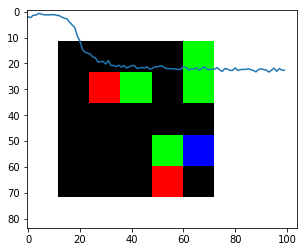

In [1]:
from __future__ import division

import gym
import numpy as np
import random
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
import scipy.misc
import os
import sys
sys.path.insert(0, '/content/drive/My Drive/lecture/l_d/p6/강화학습_강의코드/')
%matplotlib inline

from gridworld import gameEnv

#========= 게임 환경 로딩 =========#
env = gameEnv(partial=False,size=5)
#env = gym.make('Gridworld-v0')

#========= 네트워크 구현 =========#
class Qnetwork():
    def __init__(self,h_size):
        #네트워크는 게임으로부터 하나의 프레임을 받아 이를 배열로 만든다 (flattening).
        #배열의 크기를 재조절해주고 4개의 컨벌루션 레이어를 거치면서 처리해 준다.
        self.scalarInput =  tf.placeholder(shape=[None,21168],dtype=tf.float32)
        self.imageIn = tf.reshape(self.scalarInput,shape=[-1,84,84,3])
        self.conv1 = slim.conv2d( \
            inputs=self.imageIn,num_outputs=32,kernel_size=[8,8],stride=[4,4],padding='VALID', biases_initializer=None)
        self.conv2 = slim.conv2d( \
            inputs=self.conv1,num_outputs=64,kernel_size=[4,4],stride=[2,2],padding='VALID', biases_initializer=None)
        self.conv3 = slim.conv2d( \
            inputs=self.conv2,num_outputs=64,kernel_size=[3,3],stride=[1,1],padding='VALID', biases_initializer=None)
        self.conv4 = slim.conv2d( \
            inputs=self.conv3,num_outputs=h_size,kernel_size=[7,7],stride=[1,1],padding='VALID', biases_initializer=None)
        
        #마지막 컨벌루션 레이어로부터의 출력값을 취한 후, 이를 어드밴티지 스트림과 값 스트림으로 분리한다. 
        self.streamAC,self.streamVC = tf.split(self.conv4,2,3)
        self.streamA = slim.flatten(self.streamAC)
        self.streamV = slim.flatten(self.streamVC)
        self.AW = tf.Variable(tf.random_normal([h_size//2,env.actions]))
        self.VW = tf.Variable(tf.random_normal([h_size//2,1]))
        self.Advantage = tf.matmul(self.streamA,self.AW)
        self.Value = tf.matmul(self.streamV,self.VW)
        
        #최종 Q-값을 얻기 위해 어드밴티지 스트림과 값 스트림을 조합해 준다. 
        self.Qout = self.Value + tf.subtract(self.Advantage,tf.reduce_mean(self.Advantage,axis=1,keep_dims=True))
        self.predict = tf.argmax(self.Qout,1)
        
        #타겟 Q 값과 예측 Q 값 간의 제곱합 차를 취함으로써 비용을 구한다.
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,env.actions,dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
        
        self.td_error = tf.square(self.targetQ - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)
        
#========= 경험 재생 =========#
#다음 클래스는 경험과 샘플을 저장하고 랜덤하게 신경망을 학습시킨다 
        
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])        

#다음은 게임의 프레임의 사이즈를 조절해 주는 간단한 함수이다.
def processState(states):
    return np.reshape(states,[21168])

#아래 함수들은 1차 신경망의 파라미터와 함께 목표 신경망의 파라미터를 업데이트하게 해준다
def updateTargetGraph(tfVars,tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx+total_vars//2].value())))
    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)

#========= 신경망 학습 =========#

#모든 학습 파라미터를 설정한다            
batch_size = 32 #각 학습 단계에서 사용할 경험의 수
update_freq = 4 #학습 단계 기준의 업데이트 주기 
y = .99 #타겟 Q-값에 대한 할인 계수
startE = 1 #시작 시 랜덤 액션의 가능성
endE = 0.1 #종료 시 랜덤 액션의 가능성
anneling_steps = 10000. #startE에서 endE로 줄어드는데 필요한 학습 단계 수
num_episodes = 10000 #네트워크를 학습시키기 위한 게임 환경 에피소드의 수
pre_train_steps = 10000 #학습 시작 전 랜덤 액션의 단계 수
max_epLength = 50 #허용되는 최대 에피소드 길이
load_model = False #저장된 모델을 로딩할 지 여부
path = "./dqn" #모델을 저장할 경로
h_size = 512 #어드밴티지 스트림과 값 스트림으로 분리되기 전의 마지막 컨벌루션 레이어의 크기
tau = 0.001 #타겟 네트워크를 제1네트워크로 업데이트시켜 가는 비율

tf.reset_default_graph()
mainQN = Qnetwork(h_size)
targetQN = Qnetwork(h_size)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

trainables = tf.trainable_variables()

targetOps = updateTargetGraph(trainables,tau)

myBuffer = experience_buffer()

#랜덤 액션이 감소하는 비율을 설정 
e = startE
stepDrop = (startE - endE)/anneling_steps

#전체 보상과 에피소드 별 단계 수를 저장할 리스트를 생성
jList = []
rList = []
total_steps = 0

#모델이 저장될 경로 생성
if not os.path.exists(path):
    os.makedirs(path)

with tf.Session() as sess:
    sess.run(init)
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    updateTarget(targetOps,sess) #타겟 네트워크가 제1네트워크와 동일하도록 설정
    for i in range(num_episodes):
        episodeBuffer = experience_buffer()
        #환경을 리셋하고 첫번째 관찰 얻기
        s = env.reset()
        s = processState(s)
        d = False
        rAll = 0
        j = 0
        #Q-네트워크
        while j < max_epLength: #만약 에이전트가 블록에 도달하기 위해 200회 이상 시도하면 종료
            j+=1
            # Q-네트워크로부터 (e의 확률로 랜덤한 액션과 함께) 그리디하게 액션을 선택한다.
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                a = np.random.randint(0,4)
            else:
                a = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:[s]})[0]
            s1,r,d = env.step(a)
            s1 = processState(s1)
            total_steps += 1
            episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5])) #에피소드 버퍼에 경험을 저장
            
            if total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop
                
                if total_steps % (update_freq) == 0:
                    trainBatch = myBuffer.sample(batch_size) #경험에서 특정 부분을 랜덤하게 획득
                    #타겟 Q-값에 대해 double DQN 업데이트를 수행
                    Q1 = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,3])})
                    Q2 = sess.run(targetQN.Qout,feed_dict={targetQN.scalarInput:np.vstack(trainBatch[:,3])})
                    end_multiplier = -(trainBatch[:,4] - 1)
                    doubleQ = Q2[range(batch_size),Q1]
                    targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                    #타겟 값을 이용해 네트워크를 업데이트
                    _ = sess.run(mainQN.updateModel, \
                        feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]),mainQN.targetQ:targetQ, mainQN.actions:trainBatch[:,1]})
                    
                    updateTarget(targetOps,sess) #타겟 네트워크가 제1네트워크와 동일하도록 설정
            rAll += r
            s = s1
            
            if d == True:

                break
        
        myBuffer.add(episodeBuffer.buffer)
        jList.append(j)
        rList.append(rAll)
        #정기적으로 모델 저장
        if i % 1000 == 0:
            saver.save(sess,path+'/model-'+str(i)+'.cptk')
            print("Saved Model")
        if len(rList) % 10 == 0:
            print(total_steps,np.mean(rList[-10:]), e)
    saver.save(sess,path+'/model-'+str(i)+'.cptk')
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

#========= 신경망 학습 확인하기 =========#
#시간의 흐름에 따른 평균 보상

rMat = np.resize(np.array(rList),[len(rList)//100,100])
rMean = np.average(rMat,1)
plt.plot(rMean)